# Research Notebook: A study on the behaviour of the Imbalance Volume and related prices

In [1]:
import pandas as pd
import numpy as np
import math
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
import calendar
import seaborn as sns
from hurst import compute_Hc
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf

from AnalyticsModules.correlation import ClassicCorrelation

from AnalyticsModules.devotools import dickey_fuller_test, rolling_hurst

import warnings

warnings.filterwarnings('ignore')


plt.style.use('seaborn')



data = pd.read_csv('data/local_data_uk.csv', index_col = 'time', parse_dates = True)

%load_ext autoreload
%autoreload 2

# Part I: Relevant Statistics 

In [2]:
data.keys()

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       'ec00', 'ec06', 'ec12', 'ec18', 'spot_fr', 'spot_uk', 'spot_be',
       'spot_nl', 'imb_uk', 'uk_nl_spot_delta', 'uk_fr_spot_delta',
       'uk_be_spot_delta', 'uk_spot_delta', 'ec00_delta', 'ec00_lag',
       'ec00_06_delta', 'ec06_12_delta', 'ec12_18_delta', 'shifted_dir',
       'imb_vol', 'cons', 'vol_dir', 'spread'],
      dtype='object')

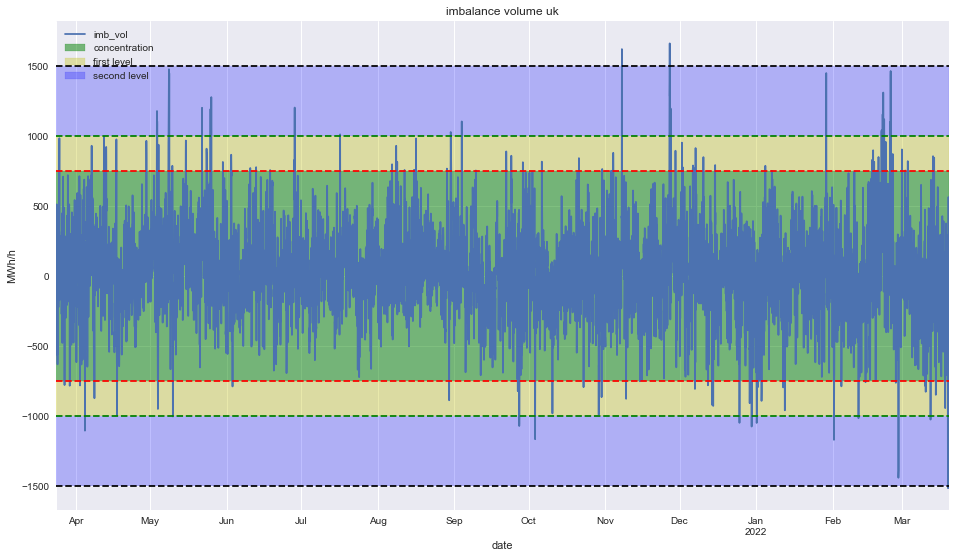

In [3]:
imbalance = data[['imb_vol']]

title = 'imbalance volume uk'

imbalance.plot(title = title, figsize = (16,9), grid = True)


#data concentration
plt.axhline(750, linestyle = '--', color = 'r')
plt.axhspan(ymin = -750, ymax = 750, color = 'g', alpha = 0.5, label = 'concentration')
plt.axhline(-750, linestyle = '--', color = 'r')

#first level dispersion
plt.axhline(1000, linestyle = '--', color = 'g')
plt.axhspan(ymin = 750, ymax = 1000, color = 'y', alpha = 0.33, label = 'first level')
plt.axhspan(ymin = -1000, ymax = -750, color = 'y', alpha = 0.33)
plt.axhline(-1000, linestyle = '--', color = 'g')


#Second level dispersion
plt.axhline(1500, linestyle = '--', color = 'k')
plt.axhspan(ymin = 1000, ymax = 1500, color = 'b', alpha = 0.25, label = 'second level')
plt.axhspan(ymin = -1500, ymax = -1000, color = 'b', alpha = 0.25)
plt.axhline(-1500, linestyle = '--', color = 'k')

plt.xlabel('date')
plt.ylabel('MWh/h')
plt.legend(loc = 'best')
plt.show()

From the above graph we can see a strong concentration of the data in a band of $[-750, 750]$ MWh/h (red bands). 
Below and above the second level of dispersion we don't see much data, therefore it makes sense to assume those data as outliers. 

In [4]:
imbalance.describe()

,imb_vol
count,8662.000000
mean,32.925585
std,303.682081
min,-1514.624000
25%,-141.981750
50%,29.776750
75%,202.273375
max,1665.086000


In [5]:
print('='*100)
print('Skewness of the Data distribution: {:.2f}'.format(imbalance.skew()[0]))
print('-'*100)
print('Kurtosis of the Data distribution: {:.2f}'.format(imbalance.kurtosis()[0]))
print('-'*100)
print('Excess of Kurtosis: {:.2f}:'.format(imbalance.kurtosis()[0] - 3))
print('-'*100)
print('Jarque Bera p-value is less than 5%:', stats.jarque_bera(imbalance.imb_vol.dropna())[1] < 0.05)
print('='*100)

Skewness of the Data distribution: 0.14
----------------------------------------------------------------------------------------------------
Kurtosis of the Data distribution: 1.80
----------------------------------------------------------------------------------------------------
Excess of Kurtosis: -1.20:
----------------------------------------------------------------------------------------------------
Jarque Bera p-value is less than 5%: True


## Remark

With the above numbers in mind we can see that the distribution of the data is rather symmetric. 
The excess of Kurtosis with respect to the Normal distribution is negative, this means that most of the data points are present
in high proximity with the mean.

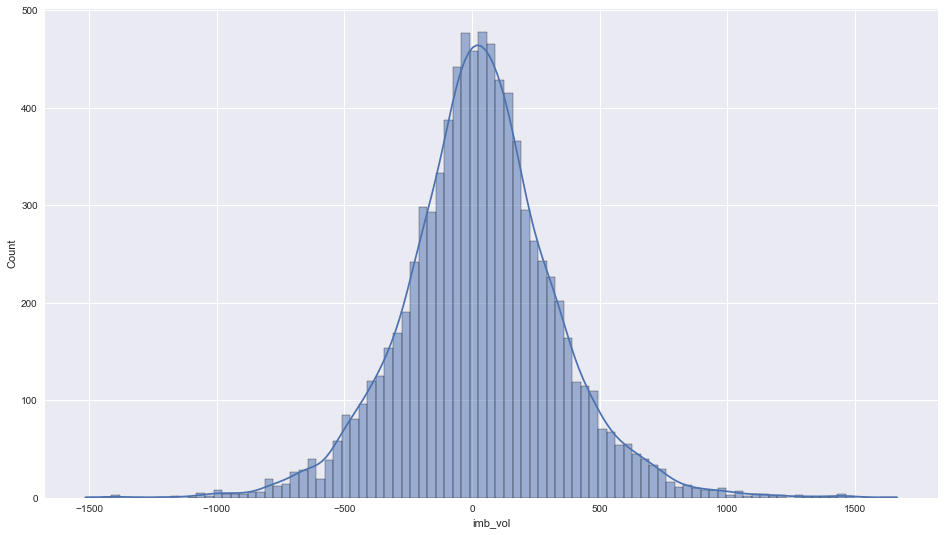

In [6]:
plt.figure(figsize = (16,9))

sns.histplot(imbalance.imb_vol.dropna(), kde = True)

plt.show()

# Part II: Relevant Econometrical Analysis

In [7]:
#Stationarity Test
dickey_fuller_test(imbalance.imb_vol.dropna())

Augmented Dickey-Fuller test
Test statistic: -12.3921
-----------------------------------
p-value: 4.764204566030282e-23
-----------------------------------
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Hypothesis Testing Results
Reject null Hyptothesis (H0): True


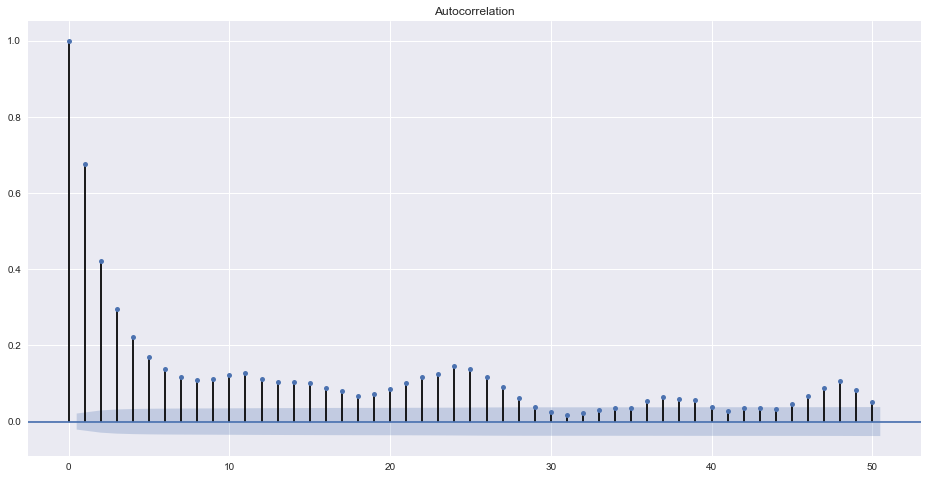

In [8]:
#How much memory has this process?


plt.rc("figure", figsize=(16,8))
acf = plot_acf(imbalance.imb_vol.dropna(), lags = 50)


### What is the behaviour of the underlying stochastic process of the residuals?

To answer at this question we use the Hurst Exponent. The Hurst exponent $H$ is a number (coming from the fractal structure of time series), which asses the general behaviour of a time series sample. It is defined as follows:

- $ H \in [0,1] $
- **if** $ H > 0.5 $ then the stochastic process persists in his behaviour (trending);
- **if** $ H = 0.5 $ then the stochastic process is a random walk;
- **if** $ H < 0.5 $ then the stochastic process anti-persists in his behaviour (mean-reversion).

In [9]:
#The imbalance volume is a mean reverting process
compute_Hc(imbalance.imb_vol.dropna())[0]

0.2059912518572521

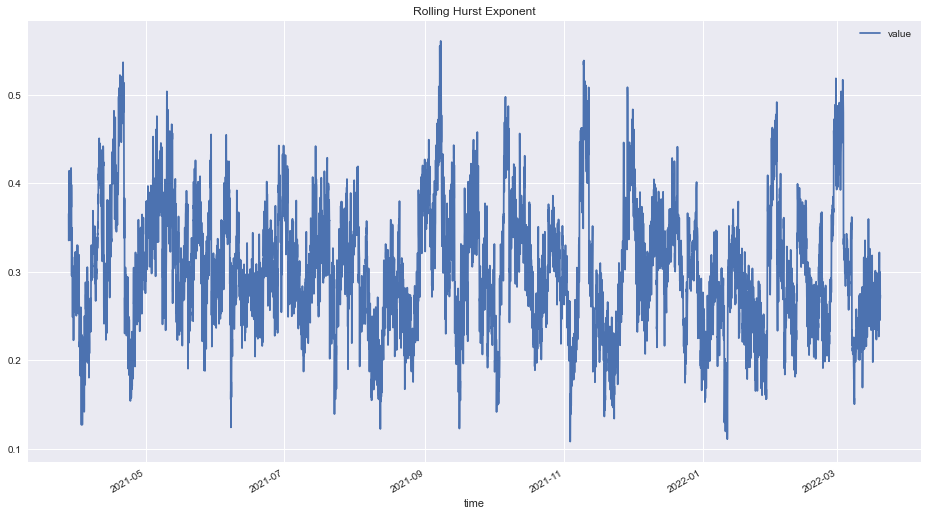

In [10]:
#We can use the Hurst exponent as an indicator to screen market trends:
#Below we see that the imbalance volume is overall mean reverting.

hr = rolling_hurst(imbalance.imb_vol.dropna(), lags = 100, plot=True)

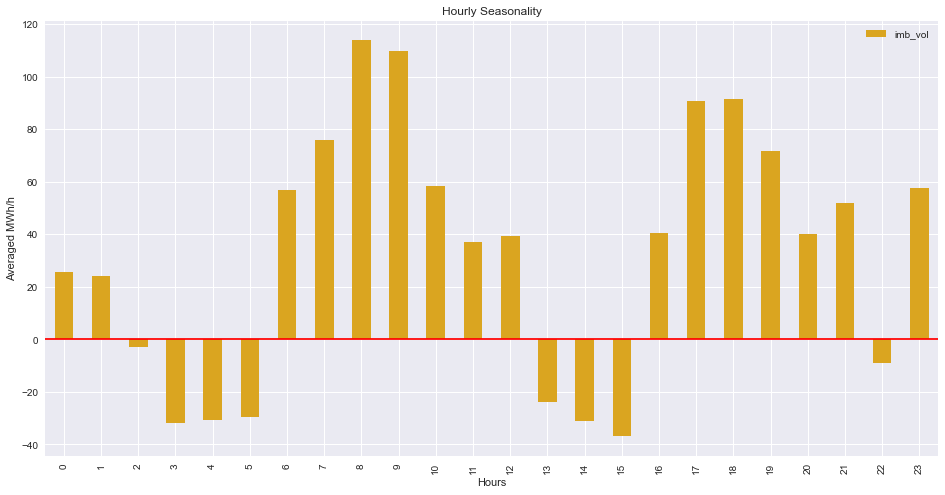

In [11]:
#Hourly seasonality of The imbalance volume

imbalance.groupby(imbalance.index.hour).mean().plot(figsize = (16, 8), 
                                                    kind = 'bar',
                                                    color = 'goldenrod',
                                                    grid = True, 
                                                    title = 'Hourly Seasonality')

plt.axhline(0, color = 'r')

plt.ylabel('Averaged MWh/h')
plt.xlabel('Hours')
plt.show()

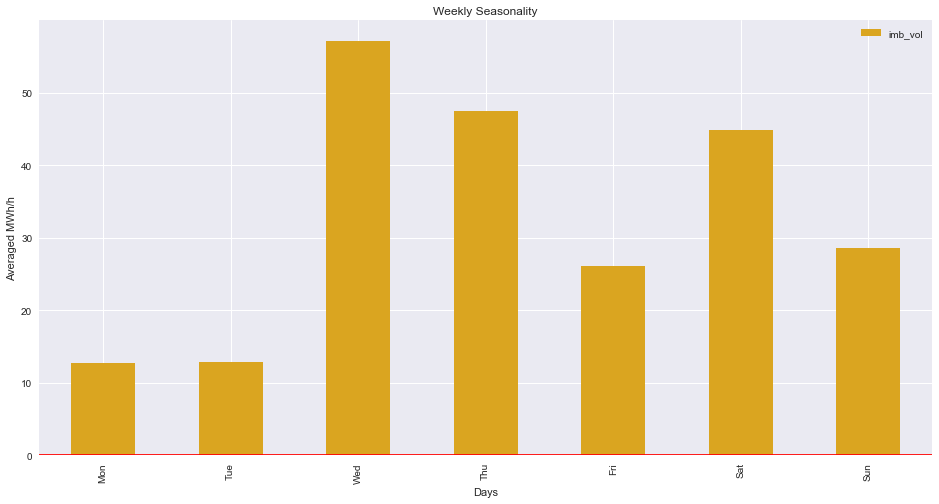

In [12]:
imb_day = imbalance.groupby(imbalance.index.weekday).mean()
imb_day.index = pd.Series(imb_day.index).apply(lambda x : calendar.day_abbr[x]).values





imb_day.plot(figsize = (16, 8), 
             kind = 'bar',
             color = 'goldenrod',
             grid = True, 
             title = 'Weekly Seasonality')

plt.axhline(0, color = 'r')

plt.ylabel('Averaged MWh/h')
plt.xlabel('Days')
plt.show()

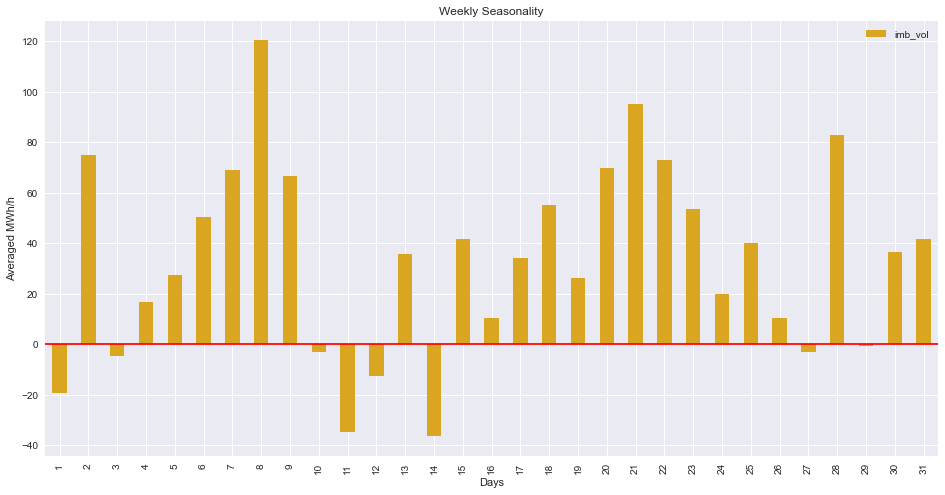

In [13]:
imb_month = imbalance.groupby(imbalance.index.day).mean()


imb_month.plot(figsize = (16, 8), 
               kind = 'bar',
               color = 'goldenrod',
               grid = True, 
               title = 'Weekly Seasonality')

plt.axhline(0, color = 'r')

plt.ylabel('Averaged MWh/h')
plt.xlabel('Days')
plt.show()

# Pre Strategy Analysis:

- H0: The direction of the volume follows the direction of the spread.
- H1: The direction of the volume anti-follows the direction of the spread.

In [16]:
from BackTestModules.Strategy.strategyZero import OneToOne, Contrarian

spread_vol = data[['imb_vol', 'spread']]

STRATEGY PERFORMANCE
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Terminal Wealth: -2990.930637
----------------------------------------------------------------------------------------------------
Number of Trades: 4724.0
Number of profitable trades: 689
Number of unprofitable trades: 4035.0
----------------------------------------------------------------------------------------------------
Density of Trades: 0.55
Hit Ratio: 0.15


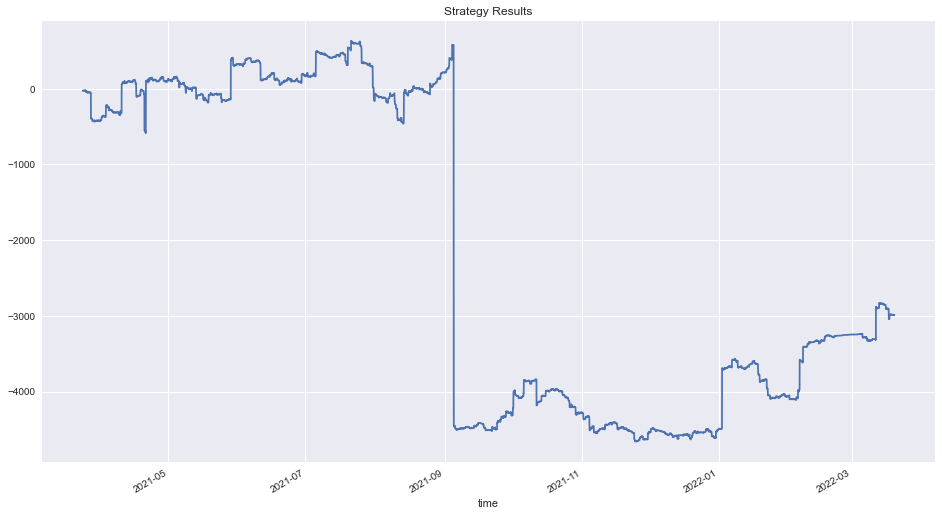

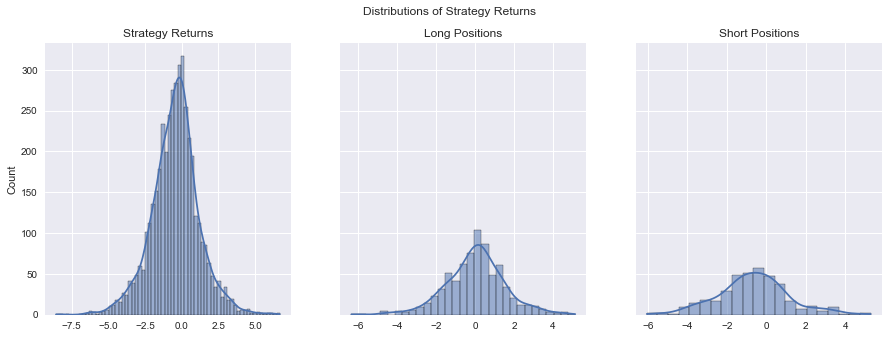

In [17]:
#Price follows direction

on = OneToOne(spread_vol)
on.test_strategy()
on.plot_results()
on.plot_diagnostics()

STRATEGY PERFORMANCE
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Terminal Wealth: 2990.930637
----------------------------------------------------------------------------------------------------
Number of Trades: 4724.0
Number of profitable trades: 1673
Number of unprofitable trades: 3051.0
----------------------------------------------------------------------------------------------------
Density of Trades: 0.55
Hit Ratio: 0.35


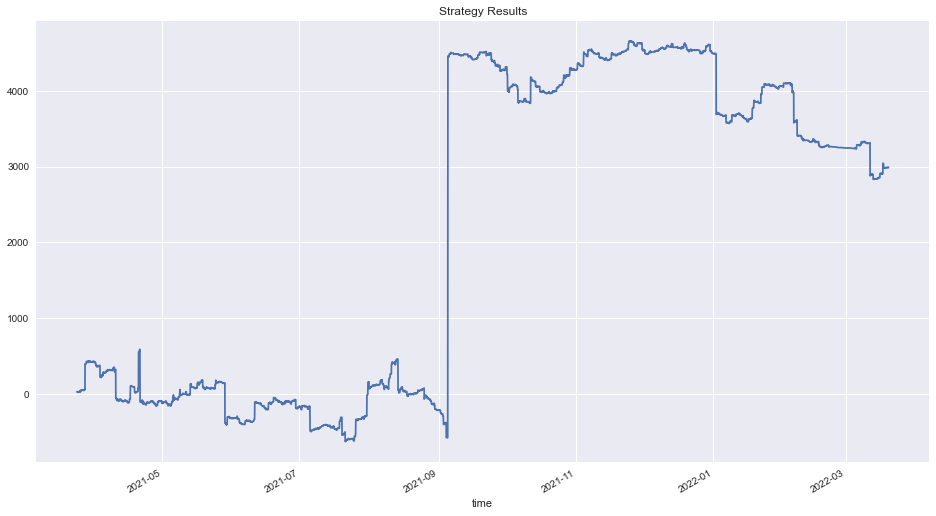

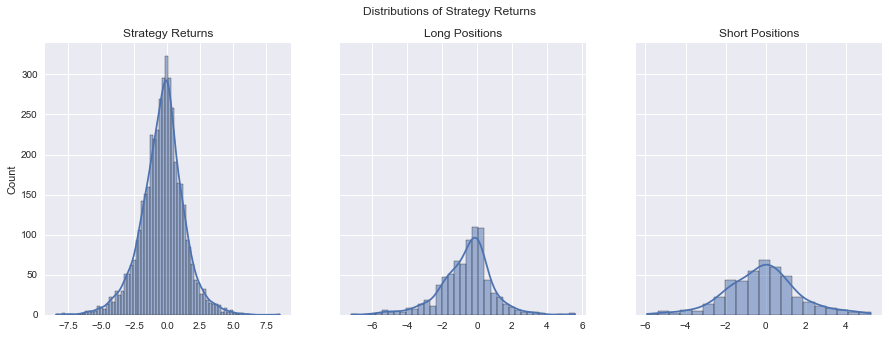

In [18]:
#Price anti-follows direction
con = Contrarian(spread_vol)
con.test_strategy()
con.plot_results()
con.plot_diagnostics()

# Conclusion

In terms of PnL it is better to go for a contrarian strategy based on mean reversion.